## 1. Environment Setup & Data Loading


In [15]:
import librosa
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Dataset Exploration & Preprocessing

In [5]:

# Load metadata CSV
df = pd.read_csv('/content/drive/MyDrive/datasets/Data/features_3_sec.csv')

# Extract genre labels from filename
df['genre'] = df['filename'].str.split('.').str[1]
df['track_id'] = df['filename'].str.split('.').str[0]

# Clean up dataframe
df.drop(['filename', 'genre'], axis=1, inplace=True)
print("Dataset Shape:", df.shape)
print("\nLabel Distribution:")
print(df['track_id'].value_counts())

Dataset Shape: (9990, 60)

Label Distribution:
track_id
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64


## 3. Audio Feature Visualization


In [7]:
def plot_audio_features(file_path, sr=22050):
    """Visualize various audio features for a sample file"""
    # Load audio file
    signal, _ = librosa.load(file_path, sr=sr)

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(14, 12))

    # Waveform
    librosa.display.waveshow(signal, sr=sr, ax=axs[0])
    axs[0].set_title('Waveform')

    # Spectrogram
    n_fft = 2048
    hop_length = 512
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(abs(stft))
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz',
                            hop_length=hop_length, ax=axs[1])
    axs[1].set_title('Spectrogram')

    # MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13,
                               n_fft=n_fft, hop_length=hop_length)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axs[2])
    axs[2].set_title('MFCC Features')

    plt.tight_layout()
    plt.show()


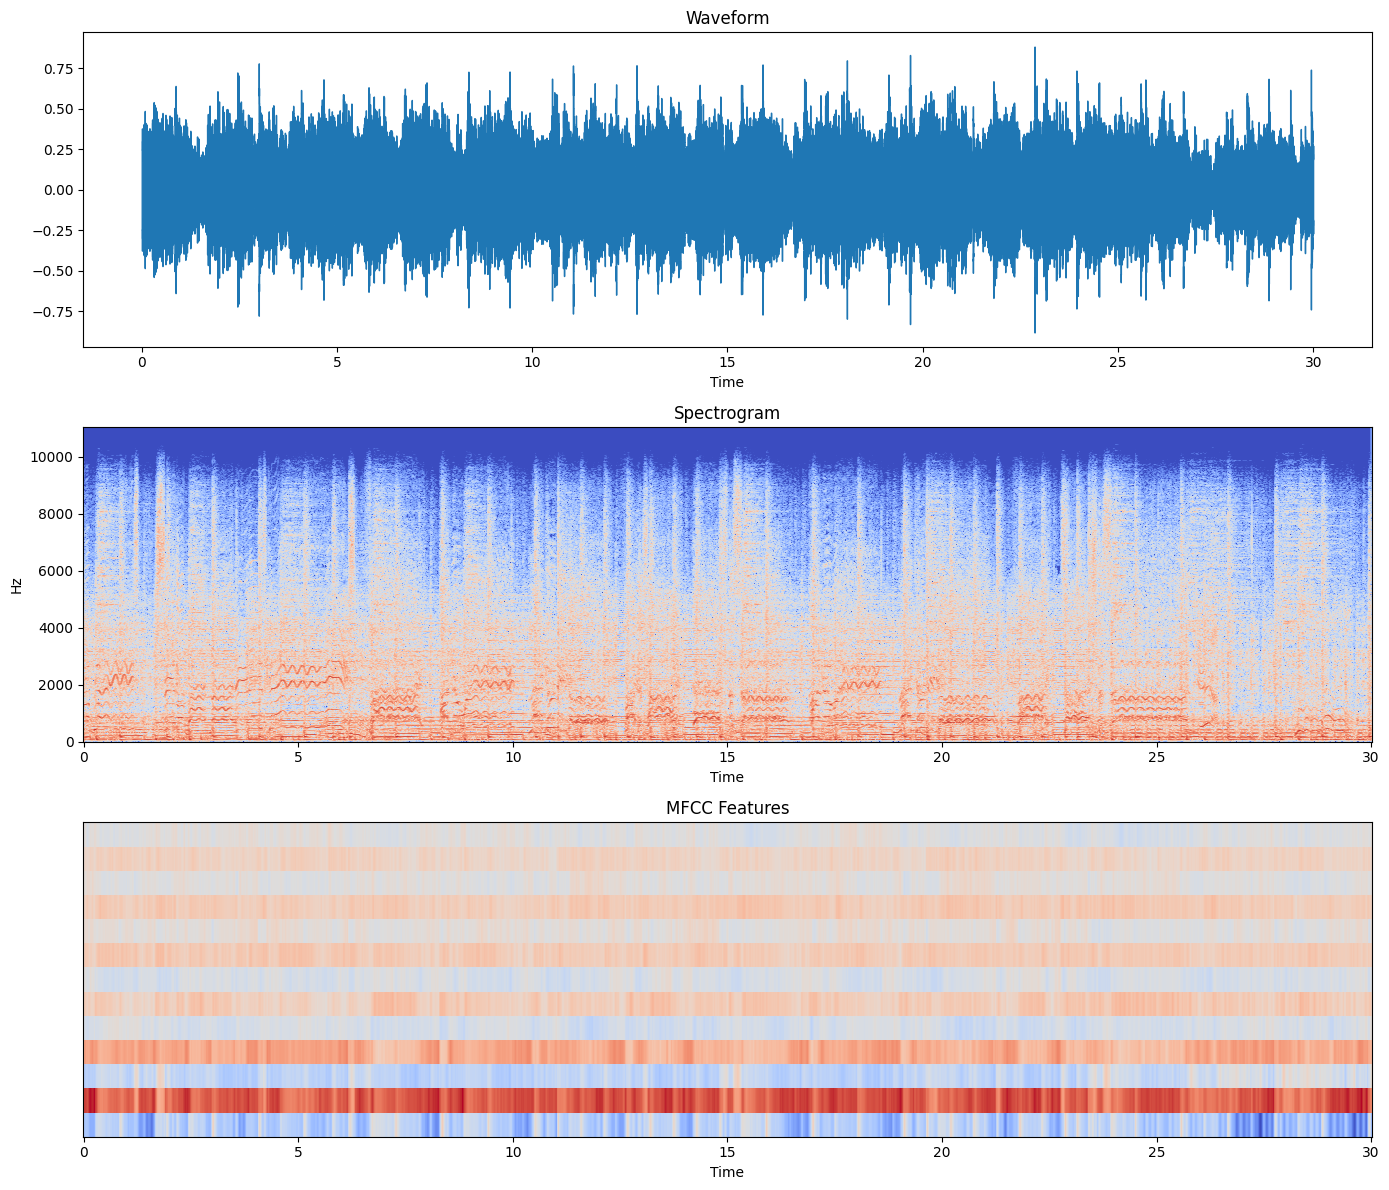

In [8]:
# Example usage
sample_file = '/content/drive/MyDrive/datasets/Data/genres_original/metal/metal.00002.wav'
plot_audio_features(sample_file)

## 4. MFCC Feature Extraction Pipeline


In [12]:
def extract_mfcc_features(dataset_path, json_path,
                         num_mfcc=13, n_fft=2048,
                         hop_length=512, num_segments=5):
    """
    Extract MFCC features from audio files and save to JSON
    Args:
        dataset_path: Path to genre directories
        json_path: Output JSON path
        num_mfcc: Number of MFCC coefficients
        n_fft: FFT window size
        hop_length: STFT hop length
        num_segments: Number of segments per track
    """
    # Audio parameters
    SAMPLE_RATE = 22050
    TRACK_DURATION = 30  # Seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

    # Data storage structure
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors = math.ceil(samples_per_segment / hop_length)

    # Process each genre directory
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath == dataset_path:
            continue  # Skip root directory

        # Get genre label from directory name
        genre = os.path.basename(dirpath)
        data["mapping"].append(genre)
        print(f"\nProcessing: {genre}")

        # Process each audio file
        for f in filenames:
            file_path = os.path.join(dirpath, f)

            try:
                # Load audio file
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                # Split into segments
                for d in range(num_segments):
                    start = samples_per_segment * d
                    end = start + samples_per_segment

                    # Extract MFCCs
                    mfcc = librosa.feature.mfcc(
                        y=signal[start:end],
                        sr=sr,
                        n_mfcc=num_mfcc,
                        n_fft=n_fft,
                        hop_length=hop_length
                    ).T  # Transpose for time-major format

                    # Store if correct length
                    if len(mfcc) == num_mfcc_vectors:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)

            except Exception as e:
                print(f"Skipped {file_path} - Error: {str(e)}")

    # Save features to JSON
    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"\nSaved features to {json_path}")

# Execute feature extraction
extract_mfcc_features(
    dataset_path='/content/drive/MyDrive/datasets/Data/genres_original',
    json_path='data.json'
)



Processing: blues

Processing: classical

Processing: country

Processing: disco

Processing: hiphop

Processing: jazz
Skipped /content/drive/MyDrive/datasets/Data/genres_original/jazz/jazz.00054.wav - Error: 

Processing: metal

Processing: pop

Processing: reggae

Processing: rock

Saved features to data.json


## 5. Model Architecture Definition


In [13]:
def build_cnn_model(input_shape, num_classes=10):
    """Build optimized CNN model architecture"""
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=input_shape),

        # Normalization layer
        keras.layers.BatchNormalization(),

        # Convolutional blocks
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),

        # Flatten for dense layers
        keras.layers.Flatten(),

        # Dense layers
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),

        # Output layer
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize model
input_shape = (259, 13, 1)  # Time steps, MFCC coefficients, channel
model = build_cnn_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 259, 13, 1)          │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 259, 13, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 129, 6, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 129, 6, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 129, 6, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 3, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 3, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 24576)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,291,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,368,782 (24.29 MB)

 Trainable params: 6,368,780 (24.29 MB)

 Non-trainable params: 2 (8.00 B)

## 6. Model Training & Evaluation


In [16]:
# Load preprocessed data
with open('data.json', 'r') as fp:
    data = json.load(fp)

X = np.array(data['mfcc'])
y = np.array(data['labels'])

# Add channel dimension for CNN
X = X[..., np.newaxis]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Training callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [17]:

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8574 - loss: 0.4229 - val_accuracy: 0.6862 - val_loss: 0.9399
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8663 - loss: 0.4134 - val_accuracy: 0.6782 - val_loss: 0.9488
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8849 - loss: 0.3828 - val_accuracy: 0.6802 - val_loss: 0.9882
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8653 - loss: 0.4072 - val_accuracy: 0.6876 - val_loss: 0.9358
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8832 - loss: 0.3719 - val_accuracy: 0.6916 - val_loss: 0.9224
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8778 - loss: 0.3840 - val_accuracy: 0.6822 - val_loss: 0.9595
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8870 - loss: 0.3445 - val_accuracy: 0.6776 - val_loss: 0.9782
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 997ms/step - accuracy: 0.8925 - loss: 0.3306 - val_accuracy: 0.6989 

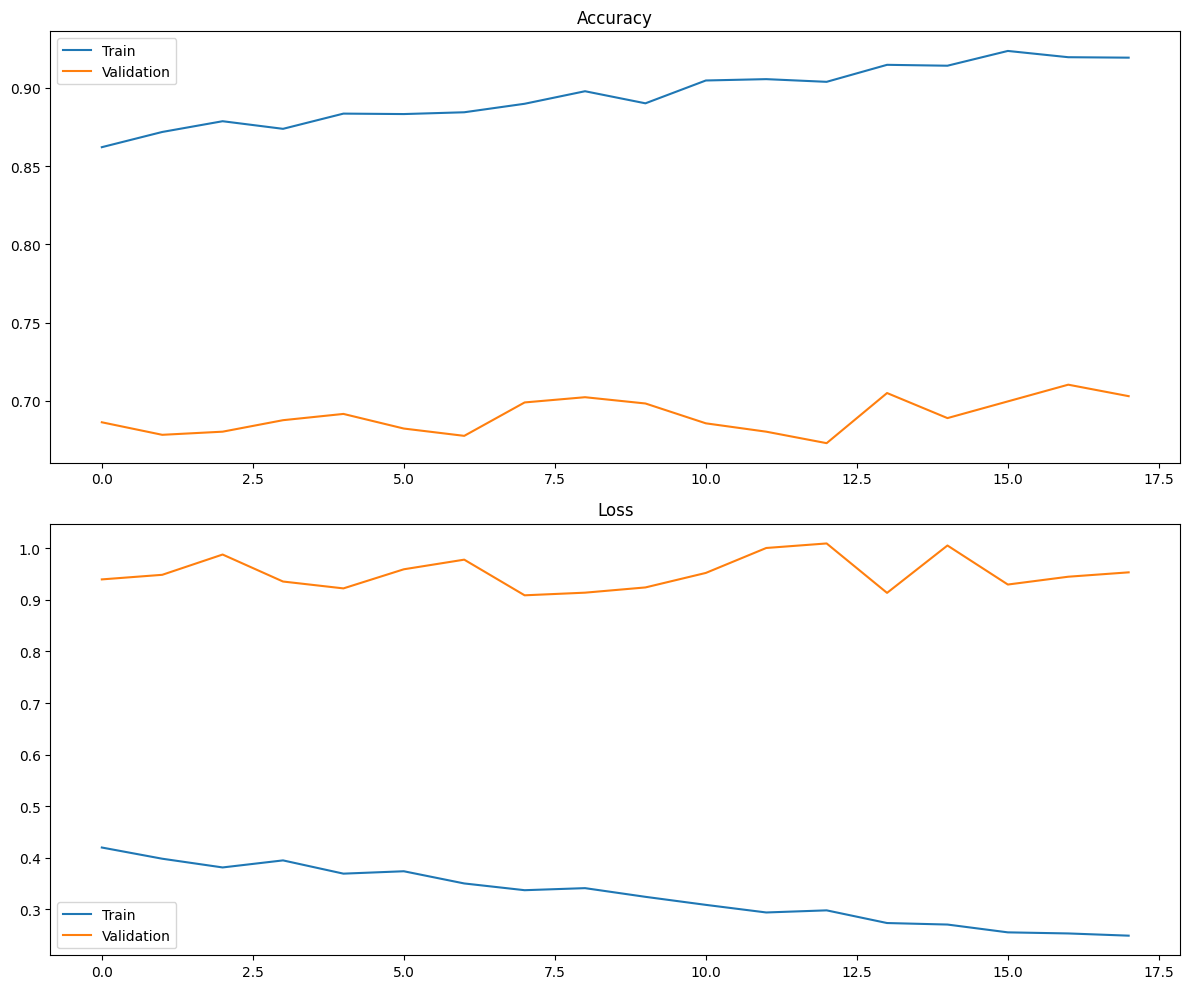

In [18]:
# Plot training history
def plot_training_history(history):
    """Visualize model training progress"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)



Test Accuracy: 69.89%
Test Loss: 0.9090
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step


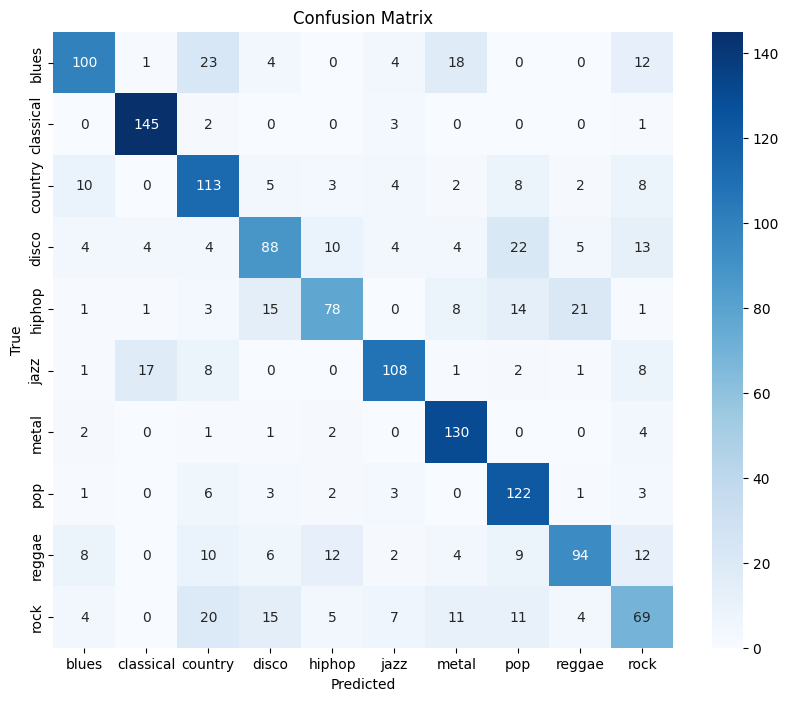


Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.62      0.68       162
   classical       0.86      0.96      0.91       151
     country       0.59      0.73      0.66       155
       disco       0.64      0.56      0.60       158
      hiphop       0.70      0.55      0.61       142
        jazz       0.80      0.74      0.77       146
       metal       0.73      0.93      0.82       140
         pop       0.65      0.87      0.74       141
      reggae       0.73      0.60      0.66       157
        rock       0.53      0.47      0.50       146

    accuracy                           0.70      1498
   macro avg       0.70      0.70      0.69      1498
weighted avg       0.70      0.70      0.69      1498



In [19]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=data['mapping'],
            yticklabels=data['mapping'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data['mapping']))


## 7. Model Saving & Inference

In [25]:
# Save model
model_path = '/content/drive/MyDrive/AI-models/music-gen-classify-v2.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

# Prediction function
def predict_genre(file_path, model):
    """Predict genre for new audio file"""
    # Feature extraction parameters
    SR = 22050
    N_MFCC = 13
    N_FFT = 2048
    HOP_LENGTH = 512
    TARGET_SHAPE = (259, 13)

    # Load and process audio
    signal, _ = librosa.load(file_path, sr=SR)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(
        y=signal,
        sr=SR,
        n_mfcc=N_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    ).T

    # Pad/truncate to target shape
    if mfcc.shape[0] > TARGET_SHAPE[0]:
        mfcc = mfcc[:TARGET_SHAPE[0], :]
    else:
        pad_width = TARGET_SHAPE[0] - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)))

    # Prepare for prediction
    mfcc = mfcc[np.newaxis, ..., np.newaxis]

    # Make prediction
    pred = model.predict(mfcc)
    return data['mapping'][np.argmax(pred)]

# Example usage
test_file = '/content/drive/MyDrive/datasets/Data/upload/user/Classical.wav'
print(f"\nPredicted genre: {predict_genre(test_file, model)}")

Model saved to /content/drive/MyDrive/AI-models/music-gen-classify-v2.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Predicted genre: classical
